# Modelling

We continue the analysing of data from Round 6 Multiple Indicator Cluster Surveys programme(MICS) focus on the urban area.

Our response variable is a binary indicator of whether a household is Moderate or Severe FI. In this notebook, we consider multilevel models to allow for and to explore between-community(clusters)
variance in Moderate or Severe. 

The data have a two-level hierarchical structure with 10,680 household at level 1, nested within 587 communities(clusters) at level 2. Since our focus is on Urban area, communities is refered to as neighborhood or clusters as defined in the survey design.

We consider a range of predictors. At level 1. We used community level poverty/wealth index by aggregating household-level variables


We conducted a preliminary check for multi-collinearity before constructing our multilevel models.

In [1]:
# Import the neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_row', 500)

In [2]:
df = pd.read_csv("../processed_data/df2.csv")

df.shape

(10680, 37)

## Model building strategy: Multilevel Logistic Regression Estimate (Multinominal Dependent variable)

<!-- To account for the categorical nature of our primary outcome variable `MSI`, which comprises
three levels displaying an intrinsic **ordinal hierarchy**, and that individual-level data is nested
within higher-level categories (i.e. clusters), we fitted a series of two-level random intercept
models to estimate the impact of **individual- and community-level** factors on food insecurity.


We employed a generalized linear mixed model with a multinomial distribution and the **CLO-
GIT** link function to compute the cumulative odds for each category of food insecurity.
This approach enabled us to account for the violation of the independence assumption and
avoid inflation of Type 1 errors. We used Statsmodel mixed effects logistic regression with maximum likelihood
with Laplace approximation (method = LAPLACE) and the CONTAIN method (DDFM = CONTAIN) to estimate the fixed effects as odds ratios (ORs) with 95% confidence
intervals (CIs) for the multilevel logistic regression estimates. 
 -->
The models fitted include;

* Null model: Model containing no predictors
* Model I: Model containing only individual-level predictors
* Model II: Model containing only community-level predictors
* Model III: Model containing both individual- and community-level predictors.


In [3]:
# Prepare the output variables
fi_mapping = {
    "0-3": 1,
    "4-6": 2,
    "7-8": 3,
}

# Apply the mapping
df["fies_0_3_7"] = df["fies_0_3_7"].map(fi_mapping)
df.to_csv("../processed_data/df_r.csv", index=False)

In [4]:
## Import the function for importing R packages in Python
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
import rpy2.robjects as ro

# Load the rpy2.ipython extension to use R magic commands in Jupyter notebooks
%load_ext rpy2.ipython
pandas2ri.activate()

In [5]:
%%R
library(tidyverse)
library(gtsummary)
library(dplyr)
library(lme4)
library(jtools)
library(car)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: carData

Attaching package: ‘car’

The following object is masked from ‘package:dplyr’:

    recode

The following object is masked from ‘package:purrr’:

    some



In [6]:
df.head()

,hh1,zone,hhsex,hh_age_cat,hh_siz_cat,helevel,hh_own_dwelling,urban_wi_quintile_mics,hh_agricultural_land,hh_own_animal,hh_ag_land_size_cat,num_child_under5_cat,num_child_5_17_cat,WORRIED,HEALTHY,FEWFOOD,SKIPPED,ATELESS,RANOUT,HUNGRY,WHLDAY,fies_score,FI_Food_Insecure,SFI,MSI,FS,fies_0_3_7,prob_mod_sev,prob_sev,num_of_women_15_49_cat,num_of_men_15_49_cat,num_of_adults_cat,num_of_children_cat,num_of_men_attended_sch_cat,num_of_women_attended_sch_cat,hhweightmics,cluster_wi_category
0,1.0,South East,Female,>45,<5,Primary,RENT,Middle,NO,NO,0 hectare,No,1,1,1,1,1,1,1,1,0,7,1,1,1,0,3,0.995,0.390,2+,0,2+,1,0,2+,0.61955,High
1,1.0,South East,Female,36-45,<5,Senior secondary,RENT,Second,NO,NO,0 hectare,No,1,1,1,1,1,1,1,0,0,6,1,0,1,0,2,0.971,0.043,2+,0,2+,1,0,2+,0.61955,High
2,1.0,South East,Male,36-45,<5,Senior secondary,OWN,Middle,NO,YES,0 hectare,Yes,1,1,0,0,1,1,1,1,0,5,1,0,1,0,2,0.875,0.002,1,0,1,2+,0,1,0.61955,High
3,1.0,South East,Male,>45,<5,No Education,OWN,Poorest,YES,YES,1-9 hectares,No,0,0,1,1,1,1,1,1,1,7,1,1,1,0,3,0.995,0.390,1,1,2+,0,1,1,0.61955,High
4,1.0,South East,Male,>45,<5,Primary,RENT,Middle,NO,NO,0 hectare,No,1,1,1,1,1,1,1,1,0,7,1,1,1,0,3,0.995,0.390,1,0,1,1,0,1,0.61955,High


#### Creating a community-level
The first step is to create the aggregated dataset using the community identifier,`hh1`.
To calculate the number of household in each community we need to calculate a
variable `nhousehold` coded 1 for all observations.

In [7]:
%%R
# Read in the data
data <- read_csv("../processed_data/df_r.csv")

data$nhousehold <- rep(1, dim(data)[1])

mydata_agg <- aggregate(cbind(data$nhousehold), by = list(data$hh1), FUN = mean, na.rm =TRUE)

# aggregate(cbind(data$nhousehold), by = list(data$hh1), FUN = sum, na.rm = TRUE)

Rows: 10680 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (19): zone, hhsex, hh_age_cat, hh_siz_cat, helevel, hh_own_dwelling, urb...
dbl (18): hh1, WORRIED, HEALTHY, FEWFOOD, SKIPPED, ATELESS, RANOUT, HUNGRY, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [55]:
%%R
# Read in the data
data <- read_csv("../processed_data/df_r.csv")


                             

data$fies_0_3_7 <- factor(data$fies_0_3_7)


# Relevel some variables
data$helevel <- factor(data$helevel, ordered = FALSE)
data$helevel <- relevel(data$helevel, ref = "No Education")

data$urban_wi_quintile_mics <- factor(data$urban_wi_quintile_mics, levels = c("Poorest","Second","Middle", "Fourth","Richest" ), ordered = FALSE)
data$urban_wi_quintile_mics <- relevel(data$urban_wi_quintile_mics, ref = "Poorest")

data$cluster_wi_category <- factor(data$cluster_wi_category, levels = c("Low", "Middle", "High"), ordered = FALSE)
data$cluster_wi_category <- relevel(data$cluster_wi_category, ref="Low")


# Convert character and cluster column to factor
data <- data %>%
  mutate(across(where(is.character), as.factor))

data <- data %>%
  mutate(across(c("SFI","FI_Food_Insecure", "MSI", "FS", "hh1" ), as.factor))

Rows: 10680 Columns: 37
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (19): zone, hhsex, hh_age_cat, hh_siz_cat, helevel, hh_own_dwelling, urb...
dbl (18): hh1, WORRIED, HEALTHY, FEWFOOD, SKIPPED, ATELESS, RANOUT, HUNGRY, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### Specifying and estimating a two-level model

We will begin by fitting a null or empty two-level model, that is a model with only
an intercept and community effects. 


$$\log\left(\frac{\pi_{ij}}{1 - \pi_{ij}}\right) = \beta_j +  u_{oj}$$


The intercept $\beta_0$ is shared by all communities(clusters) while the random effect $u_{oj}$ is
specific to community $j$. The random effect is assumed to follow a normal
distribution with variance $\sigma^2_{u0}$


In [40]:
%%R
# ?glmer

NULL


In [41]:
%%R
#make this example reproducible
set.seed(7)

fit <- glmer(formula = MSI ~ (1|hh1),
             family = binomial("logit"),
             data = data,
             # nAGQ=25,
             weights = hhweightmics,
               )
summary(fit)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: MSI ~ (1 | hh1)
   Data: data
Weights: hhweightmics

     AIC      BIC   logLik deviance df.resid 
 16937.7  16952.3  -8466.9  16933.7    10678 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.5626 -0.8030  0.4242  0.6575  3.2633 

Random effects:
 Groups Name        Variance Std.Dev.
 hh1    (Intercept) 0.5104   0.7144  
Number of obs: 10680, groups:  hh1, 575

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.99462    0.03993   24.91   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


In addition: Warning message:
In eval(family$initialize, rho) : non-integer #successes in a binomial glm!


In [42]:
%%R
summ(fit)

MODEL INFO:
Observations: 10680
Dependent Variable: MSI
Type: Mixed effects generalized linear regression
Error Distribution: binomial
Link function: logit 

MODEL FIT:
AIC = 16937.71, BIC = 16952.26
Pseudo-R² (fixed effects) = 0.00
Pseudo-R² (total) = 0.13 

FIXED EFFECTS:
-----------------------------------------------
                    Est.   S.E.   z val.      p
----------------- ------ ------ -------- ------
(Intercept)         0.99   0.04    24.91   0.00
-----------------------------------------------

RANDOM EFFECTS:
---------------------------------
 Group    Parameter    Std. Dev. 
------- ------------- -----------
  hh1    (Intercept)     0.71    
---------------------------------

Grouping variables:
-------------------------
 Group   # groups   ICC  
------- ---------- ------
  hh1      575      0.13 
-------------------------


**Important Methodology**

The estimation procedure optimizes a function of the log likelihood
using penalized iteratively re-weighted least squares. The log-likelihood is
evaluated using the **Laplacian approximation [ref](http://www.stat.columbia.edu/~cook/movabletype/archives/2010/09/r_vs_stata_or_d.html)**. This approximation method may
lead to unsatisfactory estimates....


In the glmer help file, it is noted that by specifying the option `nAGQ=n`, with n greater than 1,
changes the approximation method to adaptive **Gauss-Hermite approximation**, with a greater value
of n leading to more accurate evaluation of the log-likelihood. 
http://www.stat.columbia.edu/~cook/movabletype/archives/2010/09/r_vs_stata_or_d.html.

#### Interpretation of the null two -level model

From the model estimates (using Laplacian approximation), we can say that the log-odds of a household being Moderate or Severely FI in an 'average' cluster (one with $u_{0j}$ = 0) is estimated as $\hat{\beta}_{0}$ = 0.99681. The intercept for cluster $j$ is 0.99681 + $u{0j}$, where the variance of $u{0j}$ is estimated as $\sigma^2_{u0}$ = 0.6272.

The likelihood ratio statistic for testing null hypothesis that $\sigma^2_{u0}$ = 0, can be calculated by comparing the two-level mode, with the corresponding single-level model without the level 2 random effects

In [43]:
%%R
fita <- glm(MSI ~ 1, data = data, weights =hhweightmics,  family = binomial("logit"))
logLik(fita)-logLik(fit)

'log Lik.' -848.7937 (df=1)


In addition: Warning message:
In eval(family$initialize) : non-integer #successes in a binomial glm!


In [44]:
-2*(-398.9647)

797.9294

In [45]:
%%R
anova(fit, fita, test="Chisq")

Data: data
Models:
fita: MSI ~ 1
fit: MSI ~ (1 | hh1)
     npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
fita    1 18633 18641 -9315.6    18631                         
fit     2 16938 16952 -8466.9    16934 1697.6  1  < 2.2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


The test statistic is 797.9294 (-2*(-398.9647)) with 1 degree of freedom, so there is
strong evidence that the between-community variance is non-zero.

We will now examine estimates of the community effects or residuals, $\hat{u}_{0j}$,
obtained from the null model. Next, we will calculate the residuals and produce a
‘caterpillar plot’ with the community effects shown in rank order together with
95% confidence intervals we can us

In addition: Warning message:
In ranef.merMod(fit, postVar = TRUE) :
  ‘postVar’ is deprecated: please use ‘condVar’ instead


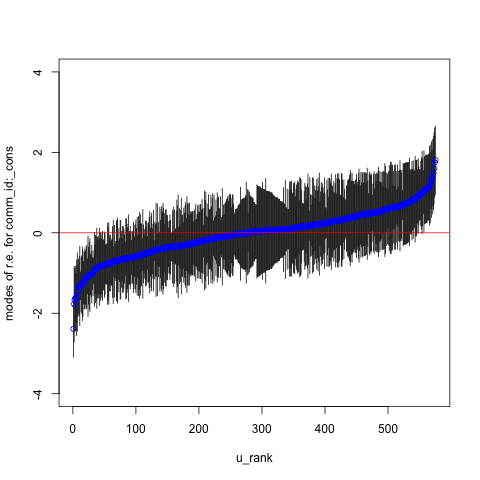

In [46]:
%%R
u0 <- ranef(fit, postVar = TRUE)
u0se <- sqrt(attr(u0[[1]], "postVar")[1, , ])
commid <- as.numeric(rownames(u0[[1]]))
u0tab <- cbind("commid" = commid, "u0" = u0[[1]], "u0se" = u0se)
colnames(u0tab)[2] <- "u0"
u0tab <- u0tab[order(u0tab$u0), ]
u0tab <- cbind(u0tab, c(1:dim(u0tab)[1]))
u0tab <- u0tab[order(u0tab$commid), ]
colnames(u0tab)[4] <- "u0rank" 

plot(u0tab$u0rank, u0tab$u0, type = "n", xlab = "u_rank", ylab = "conditional
modes of r.e. for comm_id:_cons", ylim = c(-4, 4)) 

segments(u0tab$u0rank, u0tab$u0 - 1.96*u0tab$u0se, u0tab$u0rank, u0tab$u0 +
           1.96*u0tab$u0se)
points(u0tab$u0rank, u0tab$u0, col = "blue")
abline(h = 0, col = "red")

The plot shows the estimated residuals for all 575 communities (clusters) in the sample (urban area). For
a substantial number of communities, the 95% confidence interval does not overlap
the horizontal line at zero, indicating that Moderate or Severe FI in these
communities is significantly above average (above the zero line) or below average
(below the zero line). 

### Adding an explantory variable

Next we will include household head as an explanatory variable in the model.


$$\log\left(\frac{\pi_{ij}}{1 - \pi_{ij}}\right) = \beta_0 + \beta_1hhage +  u_{oj}$$



In [47]:
%%R
fit2 <- glmer(formula = MSI ~ hh_age_cat + (1|hh1),
             family = binomial("logit"),
             data = data,
             nAGQ=25,
             weights = hhweightmics,
               )
summary(fit2)

Generalized linear mixed model fit by maximum likelihood (Adaptive
  Gauss-Hermite Quadrature, nAGQ = 25) [glmerMod]
 Family: binomial  ( logit )
Formula: MSI ~ hh_age_cat + (1 | hh1)
   Data: data
Weights: hhweightmics

     AIC      BIC   logLik deviance df.resid 
 17823.5  17859.9  -8906.7  17813.5    10675 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-8.0332 -0.7837  0.4150  0.6553  3.2558 

Random effects:
 Groups Name        Variance Std.Dev.
 hh1    (Intercept) 0.6255   0.7909  
Number of obs: 10680, groups:  hh1, 575

Fixed effects:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)      1.14769    0.10280  11.164   <2e-16 ***
hh_age_cat26-35 -0.14340    0.10633  -1.349   0.1775    
hh_age_cat36-45 -0.03848    0.10306  -0.373   0.7089    
hh_age_cat>45   -0.22635    0.10036  -2.255   0.0241 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr) h__26- h__36-
hh_g_c26-35 -0.842  

In addition: Warning message:
In eval(family$initialize, rho) : non-integer #successes in a binomial glm!


Note that there is change in the estimate od the between-cluster variance, suggesting that the distribution of household head age is different across community (clusters).

The equation of the average fitted regression line, expressin the relationship between the log-odds being Moderate or Severe FI and household head age, is: 


$$\log\left(\frac{\pi_{ij}}{1 - \pi_{ij}}\right) = 1.14769  -0.14340(hhageYoung) -0.873hhageMiddle -0.22635hhageOld + u_{oj}$$

The fitted line for a given community(cluster) will differ from the average line in its
intercept, by an amount for community $j$. A plot of the predicted community
lines will therefore show a set of parallel lines. To produce this plot, we first need
to calculate the predicted log-odds of Moderate or Severe FI for each household based on
household head age at area and community of residence. 

To do this we compute the predicted probability of Moderate or Severe FI for each household using the `fitted`
command. 

In [57]:
%%R
library(VGAM) 

In [58]:
%%R
predprob <- fitted(fit2)
predlogit <- logitlink(predprob)

### Model I: Model containing only individual/household-level predictors

In [63]:
%%R
#make this example reproducible
set.seed(7)

model1 <- glmer(formula = MSI ~ hhsex + hh_age_cat + hh_siz_cat  + 
    helevel + hh_own_dwelling + urban_wi_quintile_mics + hh_agricultural_land + 
    hh_own_animal + num_child_under5_cat +
    (1|hh1),
    family = binomial,
    data = data,
    # nAGQ=25,
    weights = hhweightmics,
    
)

In addition: Warning messages:
1: In eval(family$initialize, rho) :
  non-integer #successes in a binomial glm!
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.185146 (tol = 0.002, component 1)


In [65]:
%%R
summary(model1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: MSI ~ hhsex + hh_age_cat + hh_siz_cat + helevel + hh_own_dwelling +  
    urban_wi_quintile_mics + hh_agricultural_land + hh_own_animal +  
    num_child_under5_cat + (1 | hh1)
   Data: data
Weights: hhweightmics

     AIC      BIC   logLik deviance df.resid 
 15479.6  15625.1  -7719.8  15439.6    10660 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.6029 -0.6014  0.3386  0.6049  5.3276 

Random effects:
 Groups Name        Variance Std.Dev.
 hh1    (Intercept) 0.6293   0.7933  
Number of obs: 10680, groups:  hh1, 575

Fixed effects:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    1.51587    0.15453   9.810  < 2e-16 ***
hhsexMale                      0.02891    0.05531   0.523 0.601192    
hh_age_cat26-35                0.21673    0.11302   1.918 0.055152 .  
hh_age_cat36-45            


Correlation matrix not shown by default, as p = 19 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it



In [66]:
%%R

summ(model1, exp=T)


MODEL INFO:
Observations: 10680
Dependent Variable: MSI
Type: Mixed effects generalized linear regression
Error Distribution: binomial
Link function: logit 

MODEL FIT:
AIC = 15479.60, BIC = 15625.12
Pseudo-R² (fixed effects) = 0.16
Pseudo-R² (total) = 0.30 

FIXED EFFECTS:
----------------------------------------------------------------------
                                      exp(Est.)   S.E.   z val.      p
----------------------------------- ----------- ------ -------- ------
(Intercept)                                4.55   0.15     9.81   0.00
hhsexMale                                  1.03   0.06     0.52   0.60
hh_age_cat26-35                            1.24   0.11     1.92   0.06
hh_age_cat36-45                            1.49   0.11     3.57   0.00
hh_age_cat>45                              1.24   0.11     1.94   0.05
hh_siz_cat>5                               1.37   0.05     6.05   0.00
helevelHigher/tertiary                     1.16   0.08     1.79   0.07
helevelJunior s

In [67]:
%%R
library(gtsummary)
#Create the summary table
summary_table <- tbl_regression(model1,
                                 exponentiate = TRUE,   # Convert coefficients to odds ratios
                                 conf.level = 0.95)   
print(summary_table)

### Model II: Model containing only Community-level predictors

In [68]:
%%R
set.seed(7)
model2 <- glmer(formula = MSI ~ zone+cluster_wi_category+(1|hh1),
    family = binomial,
    data = data,
    # nAGQ=25,
    weights = hhweightmics,
)

In addition: Warning messages:
1: In eval(family$initialize, rho) :
  non-integer #successes in a binomial glm!
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.00586904 (tol = 0.002, component 1)


In [72]:
%%R
summary(model2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: MSI ~ zone + cluster_wi_category + (1 | hh1)
   Data: data
Weights: hhweightmics

     AIC      BIC   logLik deviance df.resid 
 16885.3  16950.8  -8433.6  16867.3    10671 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-7.6829 -0.8159  0.4132  0.6593  3.2033 

Random effects:
 Groups Name        Variance Std.Dev.
 hh1    (Intercept) 0.4238   0.651   
Number of obs: 10680, groups:  hh1, 575

Fixed effects:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)                 1.5128     0.2953   5.123 3.00e-07 ***
zoneNorth East             -0.7623     0.1699  -4.488 7.21e-06 ***
zoneNorth West             -0.4826     0.1450  -3.329 0.000871 ***
zoneSouth East              0.2287     0.1665   1.374 0.169591    
zoneSouth South            -0.3318     0.1431  -2.318 0.020434 *  
zoneSouth West             -0.5656     0.

In [73]:
%%R
summ(model2)

MODEL INFO:
Observations: 10680
Dependent Variable: MSI
Type: Mixed effects generalized linear regression
Error Distribution: binomial
Link function: logit 

MODEL FIT:
AIC = 16885.30, BIC = 16950.78
Pseudo-R² (fixed effects) = 0.03
Pseudo-R² (total) = 0.14 

FIXED EFFECTS:
--------------------------------------------------------------
                                   Est.   S.E.   z val.      p
------------------------------- ------- ------ -------- ------
(Intercept)                        1.51   0.30     5.12   0.00
zoneNorth East                    -0.76   0.17    -4.49   0.00
zoneNorth West                    -0.48   0.14    -3.33   0.00
zoneSouth East                     0.23   0.17     1.37   0.17
zoneSouth South                   -0.33   0.14    -2.32   0.02
zoneSouth West                    -0.57   0.12    -4.89   0.00
cluster_wi_categoryMiddle          0.27   0.29     0.93   0.35
cluster_wi_categoryHigh           -0.23   0.28    -0.81   0.42
--------------------------------

In [74]:
%%R

#Create the summary table
summary_table2 <- tbl_regression(model2,
                                 exponentiate = TRUE,   # Convert coefficients to odds ratios
                                 conf.level = 0.95)   
print(summary_table2)

### Model III: Combination of Community-level predictors and individual/household-level predictors


In [75]:
%%R
model3 <- glmer(formula = MSI ~ hhsex + hh_age_cat + hh_siz_cat  + 
            helevel + hh_own_dwelling + urban_wi_quintile_mics + 
            hh_agricultural_land + hh_own_animal + num_child_under5_cat+ 
            zone+cluster_wi_category+
            (1|hh1),
            family = binomial("logit"),
            # nAGQ=25,
            data = data,
            weights = hhweightmics,
)


In addition: Warning messages:
1: In eval(family$initialize, rho) :
  non-integer #successes in a binomial glm!
2: In checkConv(attr(opt, "derivs"), opt$par, ctrl = control$checkConv,  :
  Model failed to converge with max|grad| = 0.0336328 (tol = 0.002, component 1)


In [76]:
%%R
summary(model3)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: MSI ~ hhsex + hh_age_cat + hh_siz_cat + helevel + hh_own_dwelling +  
    urban_wi_quintile_mics + hh_agricultural_land + hh_own_animal +  
    num_child_under5_cat + zone + cluster_wi_category + (1 |      hh1)
   Data: data
Weights: hhweightmics

     AIC      BIC   logLik deviance df.resid 
 15415.6  15612.1  -7680.8  15361.6    10653 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-9.8509 -0.6015  0.3450  0.6080  5.2866 

Random effects:
 Groups Name        Variance Std.Dev.
 hh1    (Intercept) 0.5165   0.7187  
Number of obs: 10680, groups:  hh1, 575

Fixed effects:
                              Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    1.69534    0.34628   4.896 9.79e-07 ***
hhsexMale                      0.04962    0.05553   0.894 0.371575    
hh_age_cat26-35                0.23201    0.11290   2.055 0.0398


Correlation matrix not shown by default, as p = 26 > 12.
Use print(object, correlation=TRUE)  or
    vcov(object)        if you need it



In [77]:
%%R
summ(model3)

MODEL INFO:
Observations: 10680
Dependent Variable: MSI
Type: Mixed effects generalized linear regression
Error Distribution: binomial
Link function: logit 

MODEL FIT:
AIC = 15415.62, BIC = 15612.07
Pseudo-R² (fixed effects) = 0.18
Pseudo-R² (total) = 0.29 

FIXED EFFECTS:
------------------------------------------------------------------
                                       Est.   S.E.   z val.      p
----------------------------------- ------- ------ -------- ------
(Intercept)                            1.70   0.35     4.90   0.00
hhsexMale                              0.05   0.06     0.89   0.37
hh_age_cat26-35                        0.23   0.11     2.05   0.04
hh_age_cat36-45                        0.40   0.11     3.62   0.00
hh_age_cat>45                          0.22   0.11     1.95   0.05
hh_siz_cat>5                           0.32   0.05     6.03   0.00
helevelHigher/tertiary                 0.12   0.08     1.45   0.15
helevelJunior secondary                0.38   0.12     

In [78]:
%%R

#Create the summary table
summary_table3 <- tbl_regression(model3,
                                 exponentiate = TRUE,   # Convert coefficients to odds ratios
                                 conf.level = 0.95)   
print(summary_table3)

### Compare the Models

In [79]:
%%R
#compare the full model with that model that excludes `SEX`
anova(model1, model3, test="Chisq")

Data: data
Models:
model1: MSI ~ hhsex + hh_age_cat + hh_siz_cat + helevel + hh_own_dwelling + urban_wi_quintile_mics + hh_agricultural_land + hh_own_animal + num_child_under5_cat + (1 | hh1)
model3: MSI ~ hhsex + hh_age_cat + hh_siz_cat + helevel + hh_own_dwelling + urban_wi_quintile_mics + hh_agricultural_land + hh_own_animal + num_child_under5_cat + zone + cluster_wi_category + (1 | hh1)
       npar   AIC   BIC  logLik deviance  Chisq Df Pr(>Chisq)    
model1   20 15480 15625 -7719.8    15440                         
model3   27 15416 15612 -7680.8    15362 77.983  7  3.549e-14 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1
